In [3]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 7
BACK_CANDLES = 100
FUTURE_DAYS = 10

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500Daily'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary


In [4]:
import random
import copy
stock_data = create_stock_dictionary()
stock_data_copy = copy.deepcopy(stock_data)
stock_data['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-06-14,15.550000,15.581786,15.303571,15.358929,13.264135,271866000
1,2013-06-17,15.408571,15.560714,15.370000,15.428571,13.324277,259414400
2,2013-06-18,15.412857,15.532143,15.364643,15.420357,13.317183,195025600
3,2013-06-19,15.407143,15.416429,15.107143,15.107143,13.046693,310940000
4,2013-06-20,14.975000,15.213571,14.827500,14.887143,12.856695,357310800
...,...,...,...,...,...,...,...
2751,2024-05-20,189.330002,191.919998,189.009995,191.039993,191.039993,44361300
2752,2024-05-21,191.089996,192.729996,190.919998,192.350006,192.350006,42309400
2753,2024-05-22,192.270004,192.820007,190.270004,190.899994,190.899994,34648500
2754,2024-05-23,190.979996,191.000000,186.630005,186.880005,186.880005,51005900


In [5]:
#create sorted dictionary based on average 200 day closing price for training
stock_data_avg_price_dict = {}
for key in stock_data.keys():
    stock_data_avg_price_dict[key] = stock_data[key]['Close'].tail(200).mean()
stock_data_avg_price_dict = dict(sorted(stock_data_avg_price_dict.items(), key=lambda item: item[1]))

In [ ]:
from sklearn.model_selection import train_test_split
import math
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
stock_data_training = {}
stock_data_testing = {}
scalers = {}
#split data for training
for i in stock_data.keys():
    #add more features here
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    
    #MACD and Helper
    MACD = ta.macd(stock_data[i]['Close'])
    stock_data[i]['MACD'] = MACD['MACD_12_26_9']
    #stock_data[i]['MACD_Helper'] = np.where(stock_data[i]['MACD'] < MACD['MACDs_12_26_9'], -1, 0)
    #stock_data[i]['MACD_Helper'] = np.where(stock_data[i]['MACD'] > MACD['MACDs_12_26_9'], 1, 0)
    
    #RSI and Helper
    stock_data[i]['RSI'] = ta.rsi(stock_data[i]['Close'])
    #stock_data[i]['RSI_Helper'] = np.where(stock_data[i]['RSI'] <= 30, -1, 0)
    #stock_data[i]['RSI_Helper'] = np.where(stock_data[i]['RSI'] >= 70, 1, 0)
        
    #Bollinger Bands and Helper
    bbands = ta.bbands(stock_data[i]['Close'])
    stock_data[i]['BBand'] = (bbands['BBU_5_2.0'] - bbands['BBL_5_2.0']) / stock_data[i]['Close']
    
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].drop(['Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
    
    #change scaling algorithm
    scaler = MinMaxScaler(feature_range=(0,1))
    column_names = stock_data[i].columns
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
        if(column_names[k] == 'Adj Close'):
            scalers[i] = scaler
    stock_data_training[i], stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)

In [7]:
#Correlation testing
stock_data_correlation_test = copy.deepcopy(stock_data_testing['AAPL'])
stock_data_correlation_test.drop(['Date'], axis=1, inplace=True)
stock_data_correlation_test.corr()

,Adj Close,Volume,MACD,RSI,BBand,TargetNextClose
Adj Close,1.000000,-0.471274,0.451892,0.370092,-0.463353,0.989012
Volume,-0.471274,1.000000,-0.378188,-0.292018,0.596665,-0.473312
MACD,0.451892,-0.378188,1.000000,0.851724,-0.358288,0.446373
RSI,0.370092,-0.292018,0.851724,1.000000,-0.310668,0.367027
BBand,-0.463353,0.596665,-0.358288,-0.310668,1.000000,-0.464328
TargetNextClose,0.989012,-0.473312,0.446373,0.367027,-0.464328,1.000000


In [8]:
#code that lets you select which stocks you want to train on, so you can use other stocks to train
vals = list(stock_data_avg_price_dict.keys())
training_vals = vals[200:225]
training_df_list = []
for key in stock_data_training.keys():
    for item in training_vals:
        if(key == item):
            training_df_list.append(stock_data_training[key])
            

stacked_stock_data = pd.concat(training_df_list, ignore_index=True, axis=0)
stacked_stock_data = stacked_stock_data.dropna()
stacked_stock_data


,Date,Adj Close,Volume,MACD,RSI,BBand,TargetNextClose
25,2013-07-22,0.055400,0.051573,0.879978,0.794074,0.021279,0.060676
26,2013-07-23,0.060676,0.061589,0.879075,0.835237,0.022631,0.052762
27,2013-07-24,0.052762,0.037938,0.869981,0.703673,0.029453,0.053739
28,2013-07-25,0.053739,0.060062,0.861863,0.712775,0.029039,0.055595
29,2013-07-26,0.055595,0.065402,0.855323,0.730448,0.028709,0.059797
...,...,...,...,...,...,...,...
51942,2022-03-09,0.784840,0.283953,0.781612,0.461415,0.113844,0.797248
51943,2022-03-10,0.797248,0.165574,0.785653,0.498286,0.115661,0.794116
51944,2022-03-11,0.794116,0.115571,0.787253,0.487631,0.090175,0.812428
51945,2022-03-14,0.812428,0.102369,0.796002,0.543011,0.048096,0.824234


In [9]:
xs, ys = [], []
#for actual training data
for i in range(len(stacked_stock_data) - n_days - m_days + 1): 

    v = stacked_stock_data.iloc[i:(i + n_days), :-1]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days:i + n_days + m_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)


In [10]:
xs[len(xs) - 1]

array([[0.70699826, 0.15791531, 0.61433921, 0.35880856, 0.1071981 ],
       [0.70380656, 0.12575297, 0.62676271, 0.34766618, 0.06414032],
       [0.69777794, 0.14903069, 0.63546531, 0.32612881, 0.04863448],
       [0.69931466, 0.08317785, 0.64441832, 0.33406417, 0.01535189],
       [0.69635937, 0.14881746, 0.65152701, 0.32240625, 0.01960349],
       [0.70723477, 0.10201326, 0.66307827, 0.38223108, 0.01985374],
       [0.69269485, 0.23249285, 0.66701069, 0.32148045, 0.02528266],
       [0.68702079, 0.18643496, 0.66875511, 0.29907287, 0.03831413],
       [0.6904489 , 0.05927821, 0.6726934 , 0.31980534, 0.03948655],
       [0.71397253, 0.072232  , 0.68697789, 0.44773408, 0.06140966],
       [0.71243591, 0.06930007, 0.69839079, 0.44019106, 0.06831245],
       [0.72059233, 0.07582138, 0.7116069 , 0.4817448 , 0.08091991],
       [0.71089919, 0.07814916, 0.71838222, 0.43077164, 0.05972511],
       [0.7121995 , 0.07248076, 0.72477832, 0.43797288, 0.01578626],
       [0.70286082, 0.1045898 , 0.

In [11]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LeakyReLU
import keras_tuner as kt
import keras
from keras_tuner import HyperParameters, RandomSearch

num_features = xs[1].shape[1]

2024-06-06 04:56:35.234533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 04:56:35.234671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 04:56:35.356084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
'''
def build_model(hp):
    model = Sequential()
    # automatic tuning stuff (that hopefully works)
    num_layers = hp.Int('num_layers', 1, 4)
    for i in range(num_layers):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=50, max_value=200, step=20),
                       activation='relu',
                       input_shape=(n_days, num_features) if i == 0 else None,
                       return_sequences=i < num_layers - 1))
    model.add(Dense(m_days, activation='relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='lstm_tuning'
)

tuner.search(xs, ys, epochs=3, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best model architecture:")
best_model.summary()
print("Best hyperparameters:")
for param, val in best_hps.values.items():
    print(f"{param}: {val}")
'''

'\ndef build_model(hp):\n    model = Sequential()\n    # automatic tuning stuff (that hopefully works)\n    num_layers = hp.Int(\'num_layers\', 1, 4)\n    for i in range(num_layers):\n        model.add(LSTM(units=hp.Int(\'units_\' + str(i), min_value=50, max_value=200, step=20),\n                       activation=\'relu\',\n                       input_shape=(n_days, num_features) if i == 0 else None,\n                       return_sequences=i < num_layers - 1))\n    model.add(Dense(m_days, activation=\'relu\'))\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n    return model\n\ntuner = RandomSearch(\n    build_model,\n    objective=\'val_loss\',\n    max_trials=10,\n    executions_per_trial=1,\n    project_name=\'lstm_tuning\'\n)\n\ntuner.search(xs, ys, epochs=3, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])\nbest_model = tuner.get_best_models(num_models=1)[0]\nbest_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [13]:
'''
model = Sequential()
num_layers = best_hps["num_layers"]
for i in range(num_layers):
    model.add(LSTM(units= best_hps["units_" + str(i)],
                    activation='relu',
                    input_shape=(n_days, num_features) if i == 0 else None,
                    return_sequences=i < num_layers - 1))
model.add(Dense(m_days, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=8, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=2)])
'''

model = Sequential()

num_layers = 3 #best_hps["num_layers"]
#best_hps["units_" + str(i)]
for i in range(num_layers):
    model.add(LSTM(units= 40,
                    activation='relu',
                    input_shape=(n_days, num_features) if i == 0 else None,
                    return_sequences=i < num_layers - 1))
model.add(Dense(m_days, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=8, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
   5/1221 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - loss: 0.1757 

I0000 00:00:1717649812.167001     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1221/1221 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 0.0166 - val_loss: 0.0040
Epoch 2/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 5/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 6/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/8
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0019 - val_loss: 0.0025


In [58]:
X_test = []
Y_test = []
test = random.sample(training_vals, 1)[0]
test_scaler = scalers[test]
for key, df in stock_data_testing.items():
    if(key == test):
        if len(df) >= n_days + m_days:
            for i in range(len(df) - n_days - m_days + 1):
                X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())

            for i in range(len(df) - n_days - m_days + 1):
                Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [65]:
model.save("FinalModel.keras")

In [59]:
y_pred = model.predict(X_test)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [60]:
def sgn(x):
    if(x > 0):
        return 1
    if(x < 0):
        return -1
    return 0

SBUX : 2.259717218716366 percent error
Correct direction SBUX : 0.5555555555555556


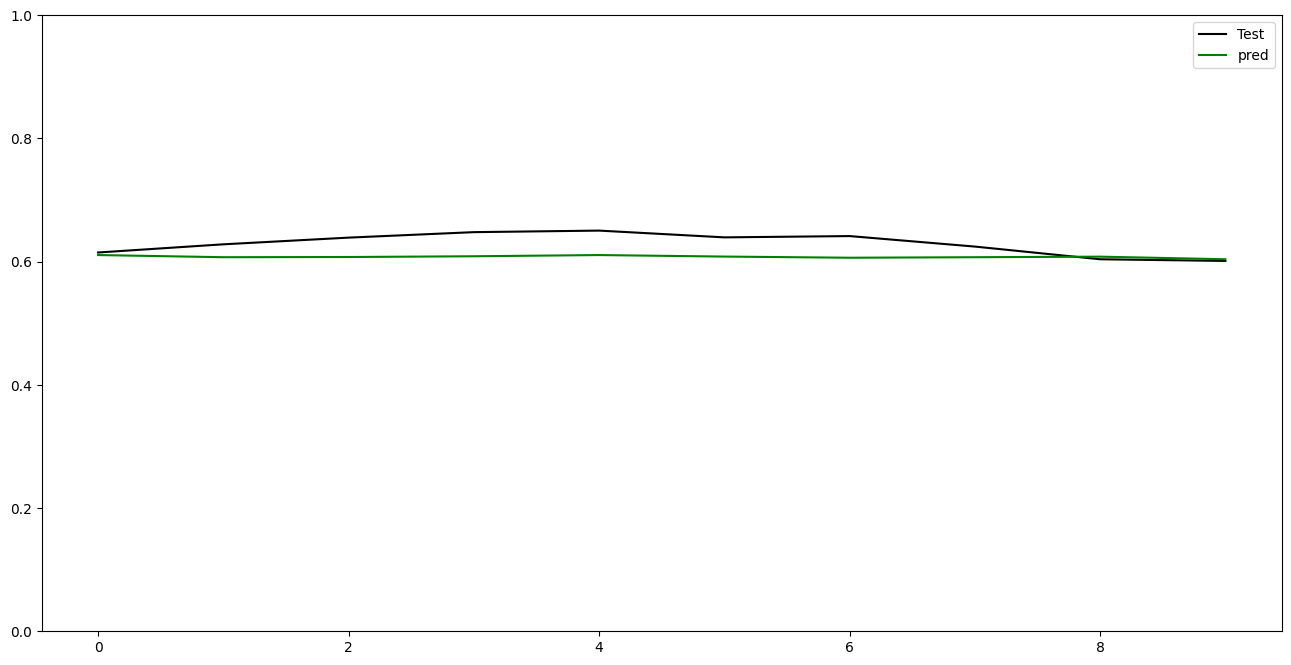

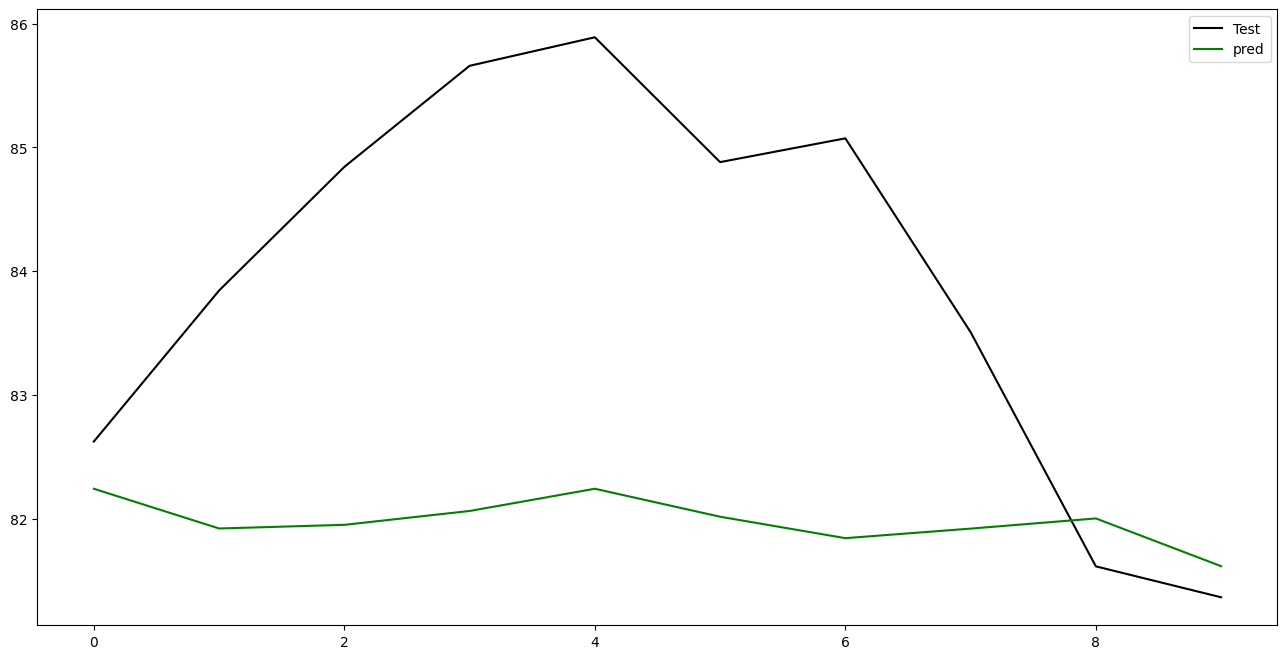

In [61]:
avg_error = 0
for i in range(len(Y_test[0])):
    avg_error += abs(Y_test[0][i] - y_pred[0][i])
print(test, ":", avg_error / len(Y_test[0]) * 100, "percent error")

direction_counter = 0
for i in range(len(Y_test[0])-1):
    if(sgn(y_pred[0][i + 1] - y_pred[0][i]) is sgn(Y_test[0][i + 1] - Y_test[0][i])):
        direction_counter += 1
print("Correct direction", test, ":", abs(direction_counter / (len(Y_test[0]) - 1)))
    
real_values_test = test_scaler.inverse_transform(Y_test)
real_values_predict = test_scaler.inverse_transform(y_pred)
plt.figure(figsize=(16,8))
a, b = 0,1
plt.ylim((a, b))
plt.plot(Y_test[0], color = 'black', label = 'Test')
plt.plot(y_pred[0], color = 'green', label = 'pred')
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(real_values_test[0], color = 'black', label = 'Test')
plt.plot(real_values_predict[0], color = 'green', label = 'pred')
plt.legend()
plt.show()